In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import mmcv
import importlib
import torch
import torchvision.transforms as transforms
from mmcv import Config
from mmcls.datasets.pipelines import Compose
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from PIL import Image
import heapq
from mmseg.apis import inference_segmentor, init_segmentor
from mmseg.core.evaluation import get_palette
import generate_segmentation
import generate_cams
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import generate_statistics
import custom_visualization

In [2]:
importlib.reload(generate_segmentation)
importlib.reload(generate_cams)
importlib.reload(generate_statistics)
importlib.reload(custom_visualization)

<module 'custom_visualization' from 'C:\\Users\\Linus\\Desktop\\XAI-Vehicle-Classification\\custom_visualization.py'>

In [32]:
configSeg = 'segmentation/ocrnet_hr48_512x512_carparts_noflip/ocrnet_hr48_512x512_carparts_noflip.py'
checkpointSeg = 'segmentation/ocrnet_hr48_512x512_carparts_noflip/latest.pth'
imgRoot = 'data/CompCars_sv_original_split/train'
configCAM = 'CAMModels/resnet/compCars_Original/resnet50_b128x2_compcars-original-split.py'
checkpointCAM = 'CAMModels/resnet/compCars_Original/latest.pth'
annfile = 'annfile.txt'
imgName='Acura_Acura_ILX_2a6cce617fc27d.jpg'
imgPath=os.path.join(imgRoot, imgName)

In [112]:
CAMConfigObj = Config.fromfile(configCAM)
pipeline = generate_statistics.get_pipeline_from_config_pipeline(CAMConfigObj.data.test.pipeline)
pipelineScale = generate_statistics.get_pipeline_from_config_pipeline(CAMConfigObj.data.test.pipeline, scaleToInt=True)

In [8]:
model = init_segmentor(configSeg,checkpointSeg, device='cuda:0')

c:\users\linus\desktop\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:225: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: segmentation/ocrnet_hr48_512x512_carparts_noflip/latest.pth


In [114]:
imgName = 'Acura_Acura_ILX_2a6cce617fc27d.jpg'
imgPath = os.path.join(imgRoot,'Acura_Acura_ILX_2a6cce617fc27d.jpg')
segMask, segImg, palette = generate_segmentation.main([imgPath, configSeg, checkpointSeg,'--types', 'masks', 'images'])
#cam = generate_cams.main([imgPath, configCAM, checkpointCAM, '--device','cuda'])
cam = generate_cams.main([imgPath, configCAM, checkpointCAM])

c:\users\linus\desktop\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:225: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: segmentation/ocrnet_hr48_512x512_carparts_noflip/latest.pth
Generate Results for file: data/CompCars_sv_original_split/train\Acura_Acura_ILX_2a6cce617fc27d.jpg


Results generated:1/1: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Generating CAM for file:data/CompCars_sv_original_split/train\Acura_Acura_ILX_2a6cce617fc27d.jpg
load checkpoint from local path: CAMModels/resnet/compCars_Original/latest.pth
Automatically choose the last norm layer as target_layer.


load checkpoint from local path: segmentation/ocrnet_hr48_512x512_carparts_noflip/latest.pth
Generate Results for file: data/CompCars_sv_original_split/train\Acura_Acura_ILX_2a6cce617fc27d.jpg


Results generated:1/1: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Generating CAM for file:data/CompCars_sv_original_split/train\Acura_Acura_ILX_2a6cce617fc27d.jpg
load checkpoint from local path: CAMModels/resnet/compCars_Original/latest.pth
Automatically choose the last norm layer as target_layer.


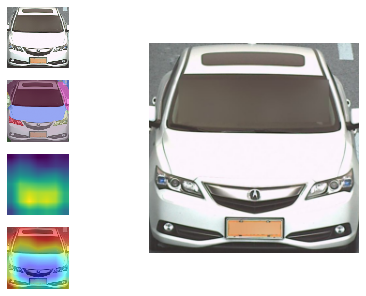

In [12]:
generate_statistics.plot_single(imgName='Acura_Acura_ILX_2a6cce617fc27d.jpg', imgRoot=imgRoot, camConfig=configCAM,
                                camCheckpoint=checkpointCAM, segConfig=configSeg, segCheckpoint=checkpointSeg)

In [115]:
transformedSegMask = transformationPipeline(segMask[imgName].astype('uint8'))
transformedSegMask = transformedSegMask.squeeze()
transformedSegMask *= 255
masks = generateUnaryMasks(transformedSegMask,segmentCount=18)

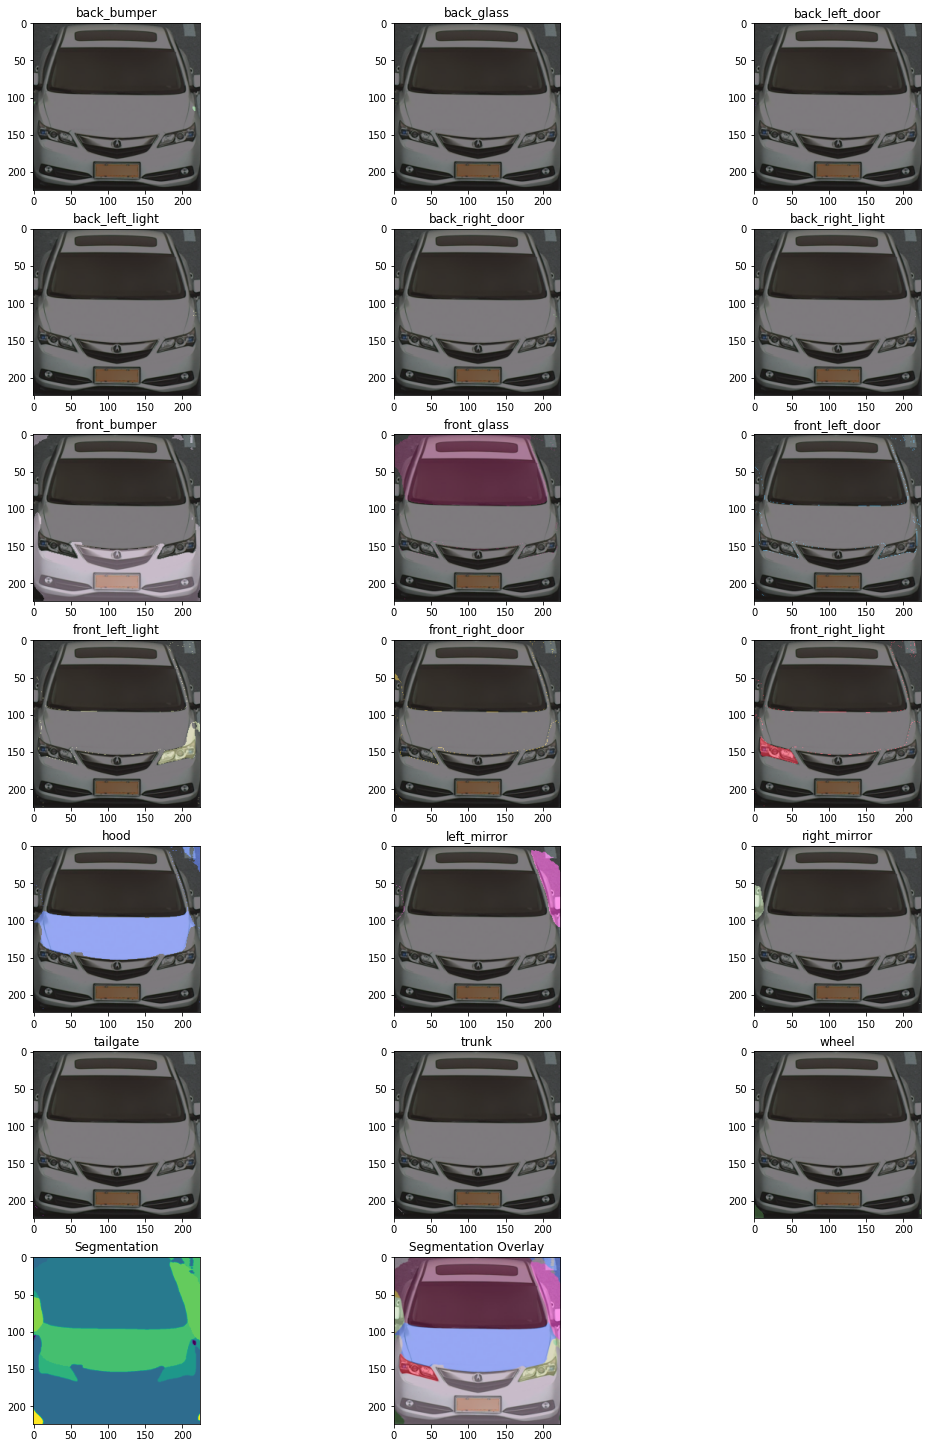

In [121]:
custom_visualization.show_segmentation_Masks_Overlay(classes=model.CLASSES, 
                                             segmentation=transformationPipeline(segMask[imgName].astype('uint8')),
                                            imgData=generate_statistics.pipeline_transform(imgPath, pipelineScale),
                                            model=model,palette=palette,
                                            segmentImageOverlay=transformedSegImg)

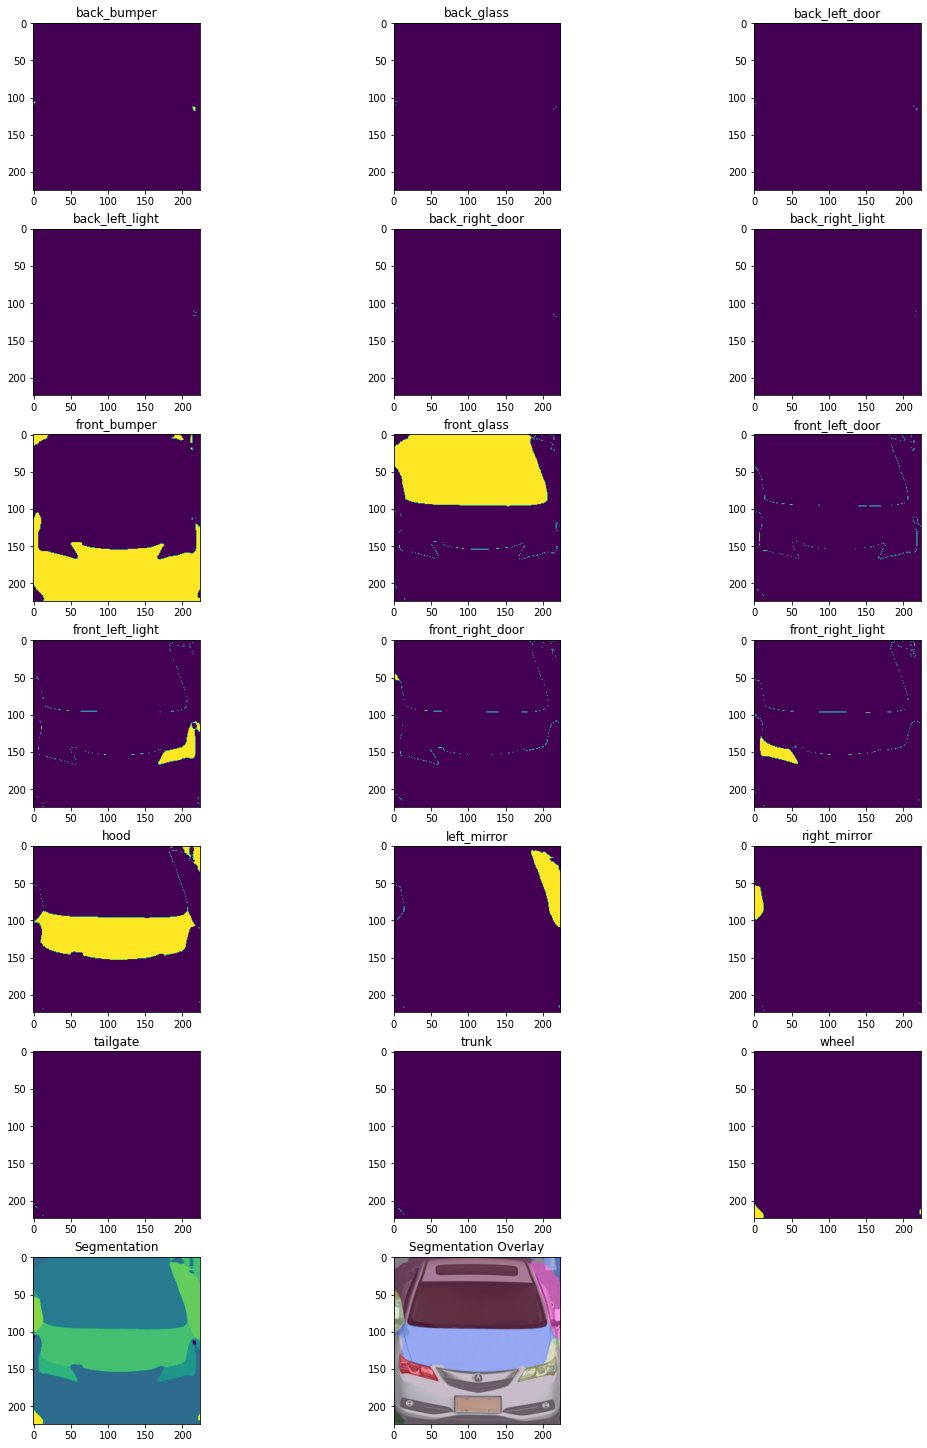

In [105]:
custom_visualization.show_segmentation_Masks(classes=model.CLASSES, 
                                             segmentation=transformationPipeline(segMask[imgName].astype('uint8')),
                                            segmentImageOverlay=transformedSegImg)

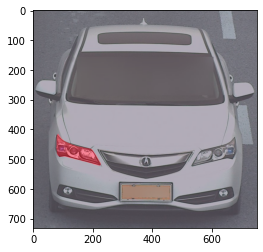

In [100]:
z = np.full(segMask[imgName].shape,5)
z[segMask[imgName]==11]=11
plt.imshow(model.show_result(imgPath, [z],palette=palette))

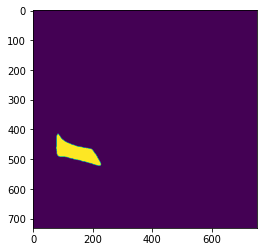

In [82]:
plt.imshow(z)